In [1]:
import numpy as np # linear algebra
from matplotlib import pyplot as plt
#We need these in this file:
import sys
sys.path.append('cropping')
import load_read_name_extractor as lrne
import SVM_classifier_general as svm_general

c:\Users\marti\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
img_list, names = lrne.load_name_and_img("cropped_min/*jpeg")

In [3]:
print(len(img_list))
print(len(names))

4915
4915


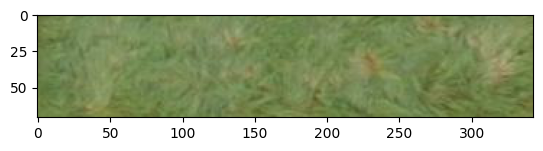

cropped_min\222_180612_Min.jpeg


In [4]:
import random

# pick a random index
random_index = random.randint(0, len(img_list)-1)

# get the corresponding image and name
random_img = img_list[random_index]
random_name = names[random_index]

# show the image and print the name
plt.imshow(random_img)
plt.show()
print(random_name)


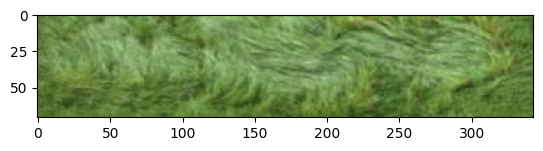

cropped_min\100_160607_Min.jpeg


In [5]:
# show the first image and print the name
plt.imshow(img_list[0])
plt.show()
print(names[0])


In [6]:
date_ = False
bin_size = 10
n_bins = int(np.floor(100/bin_size))
labels = svm_general.load_labels(bin_size, date_)
print(labels[0])
print(len(labels))

#convert names into [flight_folder, ROI]
names_labels = lrne.it_name_extract_labels_from_img_jpeg(names)
print(names_labels[0])
lodging_score = [[] for _ in range(4915)]

['179' '55' '210629_Min' '5']
4936
['100', '160607_Min']


In [7]:
#match labels with feature names
lodging_score = svm_general.match_pic_label_to_names_new(lodging_score, labels, names_labels, date_)

In [8]:
import itertools
print(lodging_score)

lodging_score_int = [[int(char) for char in sublist] for sublist in lodging_score]

flattened_list = list(itertools.chain.from_iterable(lodging_score_int))
print(flattened_list)
lodging_score = flattened_list
print(max(lodging_score_int))

[['3'], ['3'], ['0'], ['0'], ['2'], ['0'], ['5'], ['6'], ['6'], ['0'], ['1'], ['5'], ['2'], ['1'], ['0'], ['0'], ['1'], ['0'], ['4'], ['6'], ['6'], ['0'], ['0'], ['4'], ['4'], ['4'], ['0'], ['0'], ['1'], ['0'], ['5'], ['6'], ['6'], ['3'], ['4'], ['5'], ['3'], ['4'], ['0'], ['0'], ['1'], ['0'], ['5'], ['7'], ['7'], ['1'], ['3'], ['2'], ['5'], ['3'], ['0'], ['0'], ['2'], ['0'], ['4'], ['6'], ['6'], ['3'], ['3'], ['5'], ['4'], ['4'], ['0'], ['0'], ['2'], ['0'], ['5'], ['6'], ['7'], ['2'], ['3'], ['4'], ['5'], ['2'], ['0'], ['0'], ['0'], ['0'], ['4'], ['6'], ['7'], ['0'], ['0'], ['0'], ['5'], ['3'], ['0'], ['0'], ['1'], ['0'], ['4'], ['7'], ['7'], ['3'], ['3'], ['4'], ['5'], ['2'], ['0'], ['0'], ['1'], ['0'], ['4'], ['6'], ['6'], ['3'], ['4'], ['4'], ['0'], ['3'], ['0'], ['0'], ['1'], ['0'], ['4'], ['6'], ['6'], ['1'], ['2'], ['4'], ['0'], ['0'], ['0'], ['0'], ['1'], ['6'], ['6'], ['3'], ['3'], ['0'], ['0'], ['2'], ['0'], ['5'], ['7'], ['7'], ['3'], ['3'], ['5'], ['1'], ['2'], ['0'], ['2']

In [9]:
count_9 = lodging_score.count(9)
print(count_9)


1


In [10]:
print(np.shape(img_list))
print(np.shape(flattened_list))

(4915, 71, 343, 3)
(4915,)


In [11]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [124]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
class ImageDataset(Dataset):
    def __init__(self, img_list, lodging_score):
        self.img_list = img_list
        self.lodging_score = lodging_score
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img = self.img_list[idx]
        score = self.lodging_score[idx]
        # convert image to tensor
        img = torch.tensor(img).permute(2, 0, 1).float()
        return img, score
dataSet = ImageDataset(img_list, lodging_score)


#Split into train and validation set
random_seed = 10587
testValSize = (2/5) * len(dataSet)
trainDataset, testvalDataset = train_test_split(dataSet, test_size=int(testValSize), random_state=random_seed, shuffle=True)
validationSize = (1/2) * len(testvalDataset)
testDataset, valDataset = train_test_split(testvalDataset, test_size=int(validationSize), random_state=random_seed, shuffle=True)

#Create dataloaders
batchSize = 64
trainDataloader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
testDataloader = DataLoader(testDataset, batch_size=batchSize, shuffle=True)
valDataloader = DataLoader(valDataset, batch_size=batchSize, shuffle=True)

#Print sizes
print(len(trainDataset), len(testDataset), len(valDataset))
print(dataSet[0][0].shape)

2949 983 983
torch.Size([3, 71, 343])


In [113]:
import matplotlib.pyplot as plt

# Extract the labels from the trainDataloader
labels = [data[1] for data in trainDataloader]

# Count the occurrences of each label
label_counts = {}
for label in labels:
    if label.item() in label_counts:
        label_counts[label.item()] += 1
    else:
        label_counts[label.item()] = 1

# Create a bar plot
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution in trainDataloader')
plt.show()


RuntimeError: a Tensor with 64 elements cannot be converted to Scalar

In [125]:
import torch
import torch.nn as nn
import torch.nn.functional as F
num_classes = 10
channels = dataSet[0][0].shape[0]
height = dataSet[0][0].shape[1]
width = dataSet[0][0].shape[2]
print(channels)
print(height)
print(width)


3
71
343


In [126]:
input_size = 71
kernel_size = 5
padding = 0  # assuming no padding is applied
stride = 1

output_size = (input_size - kernel_size + 2 * padding) // stride + 1
print(output_size)


67


In [127]:

# define network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        #Takes in 3, 71, 343
        self.conv1 = nn.Conv2d(3,8,5, padding="same")
        self.pool = nn.AvgPool2d(2,2)
        self.conv2 = nn.Conv2d(8,8,5, padding="same")
        self.conv3 = nn.Conv2d(8,8,5, padding="same")
        self.conv4 = nn.Conv2d(8,8,5, padding="same")
        self.flatten = nn.Flatten()
        self.FC1 = nn.Linear(4*21*8, 512)
        self.FC2 = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)
        #print(x.shape)

        x = self.flatten(x)
        x = self.FC1(x)
        x = F.relu(x)
        x = self.FC2(x)
        return x


In [128]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
net = NeuralNetwork()
net.to(device)
print(net)
# Define the loss function
criterion = nn.CrossEntropyLoss().to(device)

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

# Set the number of epochs
num_epochs = 50
totalAcc = 0
# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    totalAcc = 0.0
    val_running_loss = 0.0
    val_totalAcc = 0.0
    for i, data in enumerate(trainDataloader, 0):
        # Get the inputs and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        #print(outputs.shape)
        #print(outputs[0])
        totalAcc += torch.eq(torch.argmax(outputs, dim=1), labels).sum()
        #print(torch.argmax(outputs, dim=1))
        #print(torch.argmax(outputs, dim=1).shape)
        #print(outputs.shape)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
    for i, data in enumerate(valDataloader, 0):
        net.eval()
        # Get the inputs and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass
        outputs = net(inputs)
        #print(outputs.shape)
        val_totalAcc += torch.eq(torch.argmax(outputs, dim=1), labels).sum()
        #print(torch.argmax(outputs, dim=1))
        #print(torch.argmax(outputs, dim=1).shape)
        #print(outputs.shape)
        loss = criterion(outputs, labels)

        # Print statistics
        val_running_loss += loss.item()
    scheduler.step(val_running_loss)
    net.train()
    print('[%d] train loss: %.3f train acc: %.3f val loss: %.3f val acc: %.3f ' % (epoch + 1, running_loss / len(trainDataloader), totalAcc/len(trainDataset), val_running_loss / len(valDataloader), val_totalAcc/len(valDataset)))
    running_loss = 0.0
    totalAcc = 0.0
    val_running_loss = 0.0
    val_totalAcc = 0.0

print('Finished training')


NeuralNetwork(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv3): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv4): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (FC1): Linear(in_features=672, out_features=512, bias=True)
  (FC2): Linear(in_features=512, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=None)
)
[1] train loss: 1.711 train acc: 0.480 val loss: 1.746 val acc: 0.468 
[2] train loss: 1.506 train acc: 0.508 val loss: 1.510 val acc: 0.504 
[3] train loss: 1.370 train acc: 0.536 val loss: 1.646 val acc: 0.506 
[4] train loss: 1.360 train acc: 0.544 val loss: 1.473 val acc: 0.509 
[5] train loss: 1.329 train acc: 0.542 val loss: 1.403 val acc: 0.502 
[6] train loss: 1.230 train acc: 0.564 val loss: 1.313 va

In [129]:
test_totalAcc = 0.0
test_running_loss = 0.0
for i, data in enumerate(testDataloader, 0):
    net.eval()
    # Get the inputs and labels
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    # Forward pass
    outputs = net(inputs)
    #print(outputs.shape)
    test_totalAcc += torch.eq(torch.argmax(outputs, dim=1), labels).sum()
    #print(torch.argmax(outputs, dim=1))
    #print(torch.argmax(outputs, dim=1).shape)
    #print(outputs.shape)
    loss = criterion(outputs, labels)

    # Print statistics
    test_running_loss += loss.item()
print('test loss: %.3f test acc: %.3f' % (test_running_loss / len(testDataloader), test_totalAcc/len(testDataset)))
test_totalAcc = 0.0
test_running_loss = 0.0

test loss: 1.155 test acc: 0.575
